In [79]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.signal import savgol_filter


In [80]:
# Load the file
# data_file = Path("../Data/0.8mpers-60n-0.8pas.xlsx") # Change this to the appropriate folder/file

# data_file = Path("../Data/1.5mpers-30n-11.3pas.xlsx") 
# data_file = Path("../Data/3kn-0.5.xlsx")
data_file = Path(r"E:\School\Year 3\Cheng's Lab\Data\0.3mpers-110n-11.3pas.xlsx") 
# data_file = Path(r"E:\School\Year 3\Cheng's Lab\Data\1mpers-20n-0.8pas.xlsx")
df = pl.read_excel(source=data_file, sheet_name="Analog #1")

# df = pl.read_excel(source=data_file, sheet_name="Analog")

In [81]:
## Parameter you can change
sampling_speed = 1000
speed = 0.8
data_point_length = speed / sampling_speed

In [82]:
## Process the file
header_names = df.columns
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
df = df.with_columns(
    x_data,
    ((16+pl.col("Voltage")) * 1000).alias("Left Gap [\u03bcm]"),
    ((16+((pl.col("Dev1/ai3")/250*1000)-4)*(10/16))*1000).alias("Right Gap [\u03bcm]"),
    (pl.col("Dev1/ai2")*112.3898+558.30904).alias("Load [N]")
)

ValueError: x and y must have same first dimension, but have shapes (34100,) and (400,)

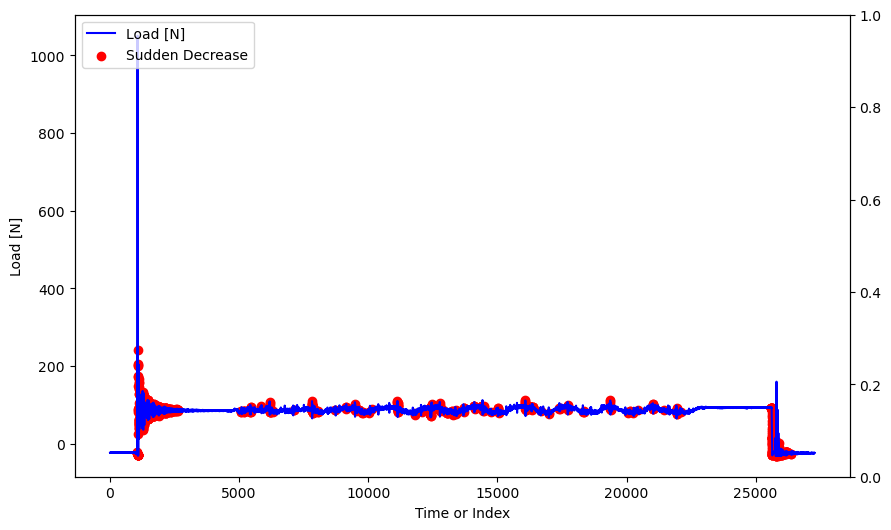

In [87]:
import polars as pl
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


load_data = df["Load [N]"]

# Smooth the Load data using Savitzky-Golay filter
smoothed_load = savgol_filter(load_data, window_length=51, polyorder=3)

# Calculate the first derivative of smoothed data
first_derivative = np.gradient(smoothed_load)

# Define an adaptive threshold for detecting sudden decreases
std_dev = np.std(first_derivative)
threshold = -0.5 * std_dev  # Adjust the multiplier as needed

# Identify sudden decrease indices
sudden_decrease_indices = np.where(first_derivative < threshold)[0]

# Plotting with Polars-integrated data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Load [N] data
ax1.plot(x_data, load_data, label="Load [N]", color="blue")
ax1.scatter(
    x_data[sudden_decrease_indices],
    load_data[sudden_decrease_indices],
    color="red",
    label="Sudden Decrease",
)
ax1.set_xlabel("Time or Index")
ax1.set_ylabel("Load [N]")
ax1.legend(loc="upper left")

# Add twin axis for gap data
ax2 = ax1.twinx()
ax2.plot(x_data, left_gap, label="Left Gap [μm]", color="orange")
ax2.plot(x_data, right_gap, label="Right Gap [μm]", color="green")
ax2.set_ylabel("Gap [μm]")
ax2.legend(loc="upper right")

# Add title and grid
plt.title("Load and Gap Analysis with Sudden Decrease Highlighted")
plt.grid()

# Save the plot
plt.savefig(f"{data_file}_highlighted.png")
plt.show()


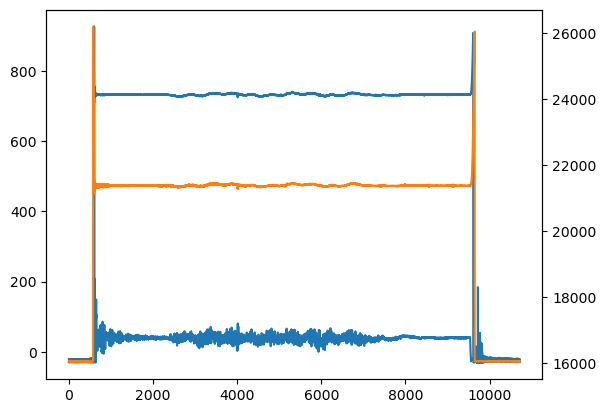

In [59]:
fig, ax1 = plt.subplots()

ax1.plot(x_data, df["Load [N]"])

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
plt.savefig(f'{data_file}.png')

In [60]:

def find_offset_portion(df, bound = 200):
    # Remove the two peaks first
    left_gap = df["Left Gap [μm]"].to_numpy()
    peaks, _ = find_peaks(left_gap)

    peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
    outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

    start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound # Take the bound away from the file

    # Refining data points again
    left_gap = left_gap[start_index:end_index]
    offset_pos = start_index
    end_pos = end_index

    peaks, _ = find_peaks(left_gap)
    peak = sorted(peaks, key = lambda x : left_gap[x], reverse=True)[0]
    start_index, end_index = peak - bound, peak + bound # The area we want to analyze
    left_gap = left_gap[start_index:end_index]
    offset_pos += start_index
    end_pos = end_index

    x_range = 2 * bound
    load = df["Load [N]"][offset_pos:offset_pos+x_range].to_numpy()
    left_gap = df["Left Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
    right_gap = df["Right Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
    x = df["Axial Distance [mm]"][offset_pos:offset_pos+x_range].to_numpy()


    load_peaks, _ = find_peaks(load)
    zero_pos = sorted(load_peaks, key = lambda x : load[x], reverse=True)[0]

    left_gap = left_gap - left_gap[zero_pos]
    right_gap = right_gap - right_gap[zero_pos]
    x = x - x[zero_pos]

    load_offset = np.mean(df.select("Load [N]").head(100).to_numpy())
    load_no_off = load
    load = load - load_offset 
    print(load_offset)

    return(x, left_gap, right_gap, load, load_no_off)

In [61]:
distance, left_gap, right_gap, load, zero_pos = find_offset_portion(df)

-21.03906771494238


In [62]:
def find_steady_portion_with_gradient(axial_distance, data, window_size=10, polyorder=2, gradient_threshold=10):
    """
    Finds the steady portion using gradient analysis and Savitzky-Golay smoothing.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze.
        window_size (int): Window size for smoothing.
        polyorder (int): Polynomial order for Savitzky-Golay filter.
        gradient_threshold (float): Threshold for identifying edges based on gradient.

    Returns:
        dict: Dictionary with edge indices, steady portion indices, and steady average.
    """
    # Step 1: Smooth the data using Savitzky-Golay filter
    smoothed_data = savgol_filter(data, window_length=window_size, polyorder=polyorder)

    # Step 2: Calculate the gradient of the smoothed data
    gradient = np.gradient(smoothed_data, axial_distance)

    # Step 3: Identify rising and lowering edges using gradient thresholds
    rising_edge_idx = np.where(gradient > gradient_threshold)[0][0]  # First large positive slope
    lowering_edge_idx = np.where(gradient < -gradient_threshold)[0][-1]  # Last large negative slope

    # Step 4: Define the steady portion as the region between edges
    steady_start_idx = rising_edge_idx + 1  # Start after the rising edge
    steady_end_idx = lowering_edge_idx - 1  # End before the lowering edge

    if steady_start_idx < steady_end_idx:
        # Filter steady portion
        steady_axial = axial_distance[steady_start_idx:steady_end_idx + 1]
        steady_data = data[steady_start_idx:steady_end_idx + 1]
        steady_average = np.mean(steady_data)

        return {
            "rising_edge_idx": rising_edge_idx,
            "lowering_edge_idx": lowering_edge_idx,
            "steady_start_idx": steady_start_idx,
            "steady_end_idx": steady_end_idx,
            "steady_average": steady_average,
            "steady_axial": steady_axial,
            "steady_data": steady_data,
        }
    else:
        print("No valid steady portion found.")
        return None
    


In [63]:
image_name = "result.png"

# Analyze steady portions for both left_gap and right_gap
result_left = find_steady_portion_with_gradient(distance, left_gap, window_size=21, polyorder=2, gradient_threshold=5)
result_right = find_steady_portion_with_gradient(distance, right_gap, window_size=21, polyorder=2, gradient_threshold=5)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Load on the primary y-axis
ax1.plot(distance, load, color="black", label="Load (N)")
ax1.set_xlabel("Axial Distance (mm)")
ax1.set_ylabel("Load (N)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_ylim(0, 200)
ax1.grid()



# Create a secondary y-axis for Left Gap and Right Gap
ax2 = ax1.twinx()
ax2.plot(distance, left_gap, color="red", label="Left Gap (μm)")
ax2.plot(distance, right_gap, color="blue", label="Right Gap (μm)")
ax2.set_ylabel("Gap (μm)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
# ax2.set_ylim(-100, 200)

# Highlight the steady portion for left_gap
if result_left:
    ax2.fill_between(
        distance[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1],
        left_gap[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1],
        alpha=0.3, color="lightgreen"
    )
else:
    print("Did not find steady state, change parameter")

# Highlight the steady portion for right_gap
if result_right:
    ax2.fill_between(
        distance[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1],
        right_gap[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1],
        alpha=0.3, color="orange"
    )
else:
    print("Did not find steady state, change parameter")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Title and show the plot
plt.title("Axial Distances vs Load and Gaps")

plt.savefig(image_name, format="png", dpi=300) 
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [53]:
output_file = "gap_averages.txt"

steady_mean = [
    result_left['steady_average'] if result_left else None,
    result_right['steady_average'] if result_right else None
]

# Extract steady portions
gap_mean = [
    np.mean(left_gap[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1]) if result_left else None,
    np.mean(right_gap[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1]) if result_right else None
]

with open(output_file, "w") as f:
    # Write the steady averages
    f.write(f"Left Gap Steady Average: {steady_mean[0]:.2f} μm\n")
    f.write(f"Right Gap Steady Average: {steady_mean[1]:.2f} μm\n\n")
    
    # Write the gap averages
    if gap_mean[0] is not None:
        f.write(f"Left Gap Average: {gap_mean[0]:.2f} μm\n")
    else:
        f.write("No steady portion data available for Left Gap.\n")
    
    if gap_mean[1] is not None:
        f.write(f"Right Gap Average: {gap_mean[1]:.2f} μm\n")
    else:
        f.write("No steady portion data available for Right Gap.\n")

In [54]:
print(f'Left Gap Steady Average: {steady_mean[0]:.2f} μm')
print(f'Right Gap Steady Average: {steady_mean[1]:.2f} μm')
print()
print(f'Left Gap Average: {gap_mean[0]:.2f} μm')
print(f'Right Gap Average: {gap_mean[1]:.2f} μm')

Left Gap Steady Average: 192.54 μm
Right Gap Steady Average: 196.98 μm

Left Gap Average: 192.54 μm
Right Gap Average: 196.98 μm
